In [3]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

/tmp/ipykernel_5582/4167336305.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Markdown, display, HTML


In [4]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [5]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [6]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green', 'rpp_bad': 'yellow'}
local_planner_symbol = {'dwb': 'o', 'rpp': '^', 'teb': 'x', 'rpp_bad': 's'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [9]:
# df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)

df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)
    
df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})


# TEMP: only consider real localization
df = df[df.localization_node != 'localization_generator']
# df = df[df.amcl_alpha_factor == 1.0]

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
run_parameters += ['max_steering_angle_deg']
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
#df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)
df['max_steering_angle_deg'] = 90    # crea una nuova colonna e riempie le righe con il valore 90
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])

metrics += ['average_velocity']
metrics_and_versions += ['average_velocity']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'std_trajectory_length'] = group_df.trajectory_length.std()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'var_trajectory_length'] = group_df.trajectory_length.var()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'mean_trajectory_length'] = group_df.trajectory_length.mean()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'median_trajectory_length'] = group_df.trajectory_length.median()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
df['norm_trajectory_length_std'] = df.trajectory_length / df.min_trajectory_length / df.std_trajectory_length
df['norm_trajectory_length_mean'] = df.trajectory_length / df.mean_trajectory_length
df['norm_trajectory_length_median'] = df.trajectory_length / df.median_trajectory_length
metrics += ['norm_trajectory_length']
metrics += ['min_trajectory_length']
metrics += ['mean_trajectory_length']
metrics += ['median_trajectory_length']
metrics += ['norm_trajectory_length_std']
metrics += ['norm_trajectory_length_mean']
metrics += ['norm_trajectory_length_median']
metrics_and_versions += ['norm_trajectory_length']
metrics_and_versions += ['mean_trajectory_length']
metrics_and_versions += ['median_trajectory_length']
metrics_and_versions += ['norm_trajectory_length_std']
metrics_and_versions += ['norm_trajectory_length_mean']
metrics_and_versions += ['norm_trajectory_length_median']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    17

## Run Parameters

    amcl_alpha_factor                                                      [0]

    environment_name                                                       ['airlab']

    global_planner_node                                                    ['global_planner']

    local_planner_node                                                     ['arena', 'dwa']

    localization_node                                                      ['amcl']

    robot_model                                                            ['turtle']

    run_index                                                              [0, 2, 4, 5, 11, 14, 15, 16]

    run_replication_index                                                  [nan, 0.0, 1.0]

    beta_1                                                                 [0.0]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.0]

    beta_4                                                                 [0.0]

    max_steering_angle_deg                                                 [90]

## Metrics

    controller_cpu_time                                                    min:          0             avg:          0             max:          0             nan:          1

    planner_cpu_time                                                       min:          0             avg:          0             max:          0             nan:          1

    system_cpu_time                                                        min:      48.29             avg:      362.7             max:      669.7             nan:          1

    controller_max_memory                                                  min:          0             avg:          0             max:          0             nan:          1

    planner_max_memory                                                     min:          0             avg:          0             max:          0             nan:          1

    system_max_memory                                                      min:      369.1             avg:      531.2             max:        667             nan:          1

    cpu_time_and_max_memory_version                                        [1]

    trajectory_length                                                      min:     0.6921             avg:      5.113             max:      13.96             nan:         10

    trajectory_length_version                                              [1]

    execution_time                                                         min:      7.833             avg:      46.85             max:      88.18             nan:         10

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.2353             max:          1             nan:          0

    success_rate_version                                                   [1]

    collision_rate                                                         min:          0             avg:     0.1176             max:          1             nan:          0

    collision_rate_version                                                 [2]

    odometry_error_alpha_1_mean                                            min:   0.004573             avg:    0.01216             max:    0.02786             nan:         10

    odometry_error_alpha_1_std                                             min:   0.005157             avg:    0.02548             max:    0.08684             nan:         10

    odometry_error_alpha_2_mean                                            min:   0.008491             avg:    0.02093             max:    0.03043             nan:         10

    odometry_error_alpha_2_std                                             min:   0.006973             avg:    0.03487             max:    0.07316             nan:         10

    odometry_error_alpha_3_mean                                            min:   0.001455             avg:   0.006251             max:   0.008917             nan:         10

    odometry_error_alpha_3_std                                             min:   0.002035             avg:   0.009118             max:     0.0152             nan:         10

    odometry_error_alpha_4_mean                                            min:  0.0002293             avg:   0.004157             max:    0.01419             nan:         10

    odometry_error_alpha_4_std                                             min:  0.0005557             avg:   0.008263             max:    0.03472             nan:         10

    odometry_error_version                                                 [2]

    localization_update_absolute_translation_error_mean                    min:     0.1036             avg:     0.1651             max:     0.2031             nan:         10

    localization_update_absolute_translation_error_std                     min:    0.01053             avg:    0.04433             max:    0.07429             nan:         10

    localization_update_absolute_rotation_error_mean                       min:   0.006706             avg:    0.01191             max:    0.02107             nan:         10

    localization_update_absolute_rotation_error_std                        min:   0.004358             avg:   0.007357             max:     0.0103             nan:         10

    localization_update_relative_translation_error_mean                    min:   0.009866             avg:    0.01321             max:    0.01808             nan:         10

    localization_update_relative_translation_error_std                     min:     0.0083             avg:   0.009786             max:    0.01152             nan:         10

    localization_update_relative_rotation_error_mean                       min:   0.004019             avg:   0.004552             max:   0.004975             nan:         10

    localization_update_relative_rotation_error_std                        min:   0.002783             avg:   0.003413             max:   0.004137             nan:         10

    localization_update_normalized_relative_translation_error_mean         min:     0.1535             avg:     0.2889             max:     0.4258             nan:         10

    localization_update_normalized_relative_translation_error_std          min:     0.2399             avg:     0.3317             max:     0.5133             nan:         10

    localization_update_normalized_relative_rotation_error_mean            min:      0.026             avg:    0.03874             max:    0.04979             nan:         10

    localization_update_normalized_relative_rotation_error_std             min:    0.02523             avg:    0.04259             max:    0.08372             nan:         10

    localization_update_error_version                                      [1]

    localization_update_rate                                               min:     0.2762             avg:      1.168             max:      2.002             nan:         10

    localization_update_rate_std                                           min:     0.1025             avg:       2.41             max:      5.111             nan:         10

    localization_update_rate_version                                       [1]

    average_translation_velocity                                           min:    0.05562             avg:     0.1205             max:     0.2259             nan:         10

    average_rotation_velocity                                              min:    0.07591             avg:     0.2429             max:     0.7334             nan:         10

    translation_rotation_product                                           min:    0.01272             avg:    0.03343             max:    0.07523             nan:         10

    average_translation_acceleration                                       min:    0.05456             avg:     0.0899             max:      0.146             nan:         10

    average_rotation_acceleration                                          min:    0.06958             avg:     0.2126             max:     0.3805             nan:         10

    translation_rotation_acceleration_product                              min:   0.009935             avg:    0.02731             max:    0.06592             nan:         10

    motion_characteristics_version                                         [3]

    average_velocity                                                       min:    0.04446             avg:    0.09487             max:     0.1851             nan:         10

    norm_trajectory_length                                                 min:          1             avg:      1.054             max:      1.215             nan:         13

    mean_trajectory_length                                                 min:     0.6921             avg:      10.85             max:      12.73             nan:          6

    median_trajectory_length                                               min:     0.6921             avg:      10.85             max:      12.73             nan:          6

    norm_trajectory_length_std                                             min:     0.5735             avg:      0.635             max:     0.6965             nan:         15

    norm_trajectory_length_mean                                            min:     0.9031             avg:          1             max:      1.097             nan:         13

    norm_trajectory_length_median                                          min:     0.9031             avg:          1             max:      1.097             nan:         13

    norm_execution_time                                                    min:          1             avg:      1.105             max:       1.42             nan:         13

In [23]:
df[df.execution_time.isna()]['run_id']


2     session_2022-08-11_15-16-16_261512_run_000000001
4     session_2022-08-12_12-32-54_864279_run_000000000
5     session_2022-08-12_12-34-05_726705_run_000000000
10    session_2022-09-04_11-20-25_667321_run_000000000
11    session_2022-09-04_11-35-18_203085_run_000000000
12    session_2022-09-04_11-53-15_763168_run_000000000
13    session_2022-09-04_12-21-26_746332_run_000000000
14    session_2022-09-04_12-35-00_654120_run_000000000
15    session_2022-09-04_12-46-26_384669_run_000000000
16    session_2022-09-04_12-59-18_484085_run_000000000
Name: run_id, dtype: object

In [21]:
np.nan == np.nan

False

In [6]:
df[['run_id', 'collision_rate']]

,run_id,collision_rate
0,session_2022-07-29_12-46-23_384597_run_000000000,0
1,session_2022-07-29_12-56-08_037686_run_000000000,0
2,session_2022-08-11_15-16-16_261512_run_000000001,0
3,session_2022-08-11_15-38-35_112598_run_000000002,0
4,session_2022-08-12_12-32-54_864279_run_000000000,0
5,session_2022-08-12_12-34-05_726705_run_000000000,0
6,session_2022-08-12_12-56-06_683404_run_000000000,0
7,session_2022-08-12_13-15-32_973934_run_000000000,0
8,session_2022-08-12_13-15-32_973934_run_000000001,0


In [7]:
printmd("## Overall performance values by robot model, local planner component, kinematic constraints, and localization component")
printmd("### Considering all runs (sorted by collisionless success rate)")
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('success_rate', 'mean'), ascending=False)

## Overall performance values by robot model, local planner component, kinematic constraints, and localization component

### Considering all runs (sorted by collisionless success rate)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                                mean count           mean count             mean count                   mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                                                      
turtle      arena              90                     amcl                     1.000     2              0     2            0.172     2                  1.107     2               1.210     2
            dwa                90                     amcl                     0.143     7              0     7            0.058     4                  1.000     1               1.000     1

In [8]:
printmd("### Only considering successful runs (sorted by norm trajectory length)")
df[df.success_rate == 1].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('norm_trajectory_length', 'mean'), ascending=True)

### Only considering successful runs (sorted by norm trajectory length)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                                mean count           mean count             mean count                   mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                                                      
turtle      dwa                90                     amcl                         1     1              0     1            0.059     1                  1.000     1               1.000     1
            arena              90                     amcl                         1     2              0     2            0.172     2                  1.107     2               1.210     2

In [9]:
printmd("### Only considering failed runs (sorted by collision rate)")
df[df.success_rate == 0].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('collision_rate', 'mean'), ascending=True)

### Only considering failed runs (sorted by collision rate)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                                mean count           mean count             mean count                   mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                                                      
turtle      dwa                90                     amcl                         0     6              0     6            0.058     3                    nan     0                 nan     0

## success rate

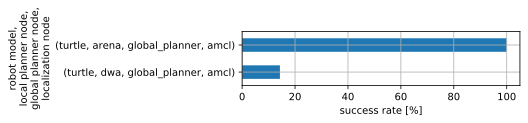

## collision_rate

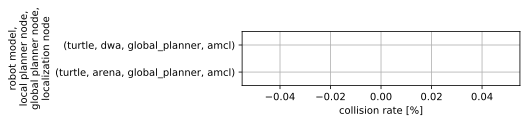

## average_velocity, only successful runs

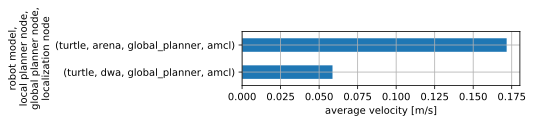

## norm_trajectory_length, only successful runs

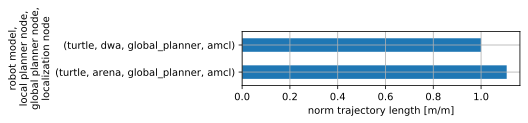

## norm_execution_time, only successful runs

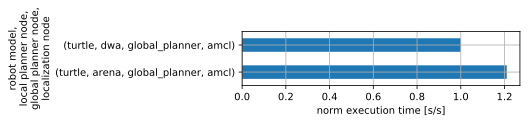

In [10]:
def bar_plot(metric_name, selected_df, y_columns=['robot_model', 'local_planner_node', 'global_planner_node', 'localization_node'], percentage=False, unit_symbol=None, higher_better=True):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=higher_better)
    ax = (bar_df.sort_values(by=('mean'), ascending=higher_better)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True, legend=False)
    ax.set_xlabel(metric_name.replace('_', ' ').replace(',', ', ') + (f" [{unit_symbol}]" if unit_symbol else ""))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ',\n'))
    plt.gcf().set_size_inches([5, 1])
    plt.show()
printmd("## success rate")
bar_plot(metric_name='success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=True, unit_symbol='%')
printmd("## collision_rate")
bar_plot(metric_name='collision_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=False, unit_symbol='%')
printmd("## average_velocity, only successful runs")
bar_plot(metric_name='average_velocity', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=True, unit_symbol='m/s')
printmd("## norm_trajectory_length, only successful runs")
bar_plot(metric_name='norm_trajectory_length', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='m/m')
printmd("## norm_execution_time, only successful runs")
bar_plot(metric_name='norm_execution_time', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='s/s')

In [11]:
max_scatter_points = 200
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir, min_y=0.0, plot_all=True, scatter=True):
    max_y = -np.inf
#     scatter = False

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization_node in df.localization_node.unique():
            for local_planner_node in df.local_planner_node.unique():
                
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if scatter:
                        n = max(1, int(len(df_lr[input_metric.name])/max_scatter_points))
                        plt.scatter(df_lr[input_metric.name][::n], df_lr[output_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner_node])
                    
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max() + bin_width, bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([min_y, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


In [12]:
printmd("## Localization perf from system features")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.average_velocity, 0.02], 
    [d.average_translation_velocity, 0.02], 
    #[d.average_velocity_atan, 0.1],
    [d.beta_1, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )


printmd("## Localization perf from own parameters")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0)].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.amcl_alpha_factor, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )

## Localization perf from system features

AttributeError: 'DataFrame' object has no attribute 'absolute_translation_error'

In [ ]:
# printmd("## avg vel and avg vel atan are similar")
# d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics = [
#     d.average_translation_velocity,
#     d.average_rotation_velocity,
#     d.average_velocity_atan,
# ]
# bin_widths = [0.02, 0.05, 0.1]
# min_bin_count = 10
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_translation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_rotation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_velocity_atan, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )

In [ ]:

# print(df.goal_index)

bin_widths = [None, None, None]
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics = [
    d.environment_name,
    d.run_duplicate_index,
    d.goal_index,
]

plot_in_out_metrics_bin_width_save(
    output_metric=d.minimum_clearance, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)

In [ ]:

# printmd("### norm trajectory length ← absolute translation error doesn't work because when absolute translation error is very small, the trajectories are very short and a small change in trajectory length causes a big change in norm trajectory length")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.01]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.absolute_translation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
    
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


In [ ]:

# printmd("### norm trajectory length, trajectory length ← other localization error metrics")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.03]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.normalized_relative_rotation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


In [ ]:


for e in df.environment_name.unique():
    printmd(f"## {e}")
    min_bin_count = 10
    d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
    bin_widths = [1, .1, .01]
    input_metrics = [
        d.maximum_clearance, 
        d.average_clearance, 
        d.minimum_clearance, 
    ]
    plot_in_out_metrics_bin_width_save(
        output_metric=d.average_velocity, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        min_y=0.0,
        plot_all=False,
        scatter=True,
        out_dir=f"thesis_plots/local_planner/{e}",
    )


In [ ]:

printmd("## Local Planning perf (also system features)")

min_bin_count = 10
d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity_atan, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)

In [ ]:
## plots_local_planner

printmd("## Local Planning perf (not system features)")

min_bin_count = 10

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.success_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.collision_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)

d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_trajectory_length, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_execution_time, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)

In [ ]:
# ## plots_local_planner

# min_bin_count = 10

# d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics, bin_widths = zip(*[
# #     [d.beta_1, None], 
# #     [d.amcl_alpha_factor, None],
# #     [d.minimum_clearance, .1],
# #     [d.average_clearance, 1],
#     [d.absolute_translation_error, 0.05],
#     [d.absolute_rotation_error, 0.01],
#     [d.normalized_relative_translation_error, 0.05],
#     [d.normalized_relative_rotation_error, 0.05],
# ])

# printmd("## norm_trajectory_length")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_std")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_std, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_mean")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_mean, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_median")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_median, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )

In [ ]:
df_s = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()

bins = np.arange(df_s.trajectory_length.min(), df_s.trajectory_length.max(), 5)
df_s['trajectory_length_d'] = pd.cut(df_s.trajectory_length, bins, labels=bins[:-1]).astype('float')
df_lr_g = df_s.groupby('trajectory_length_d').agg(['mean', 'count'])

plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label='all', color='black', linewidth=4)

for environment_name in df_s.environment_name.unique():
    df_lr_g = df_s[df_s.environment_name == environment_name].groupby('trajectory_length_d').agg(['mean', 'count'])
    plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label=environment_name)

plt.xlabel('trajectory_length_d')
plt.ylabel('absolute_translation_error')
plt.legend()
plt.grid()
plt.show()